# Time Series Models
This is mostly extracted from https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/, as an exercise for learning time series models.

In [2]:
from matplotlib import pyplot as plt
import pandas as pd

## 1. Autoregression(AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.  

X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)....

An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step.

In [2]:
# ! python3 -m pip install scipy==1.2 --upgrade

In [1]:
from statsmodels.tsa.ar_model import AutoReg
from random import random

### Example 1

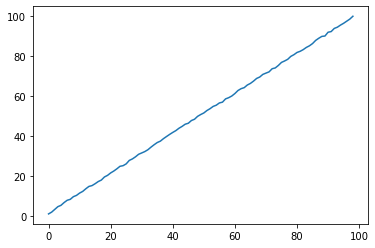

In [6]:
# contrived dataset
data = [x + random() for x in range(1, 100)]
plt.plot(data)

In [9]:
# Fit AR
model = AutoReg(data, lags=1)
model_fit = model.fit()
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.95489859]


### Example 2

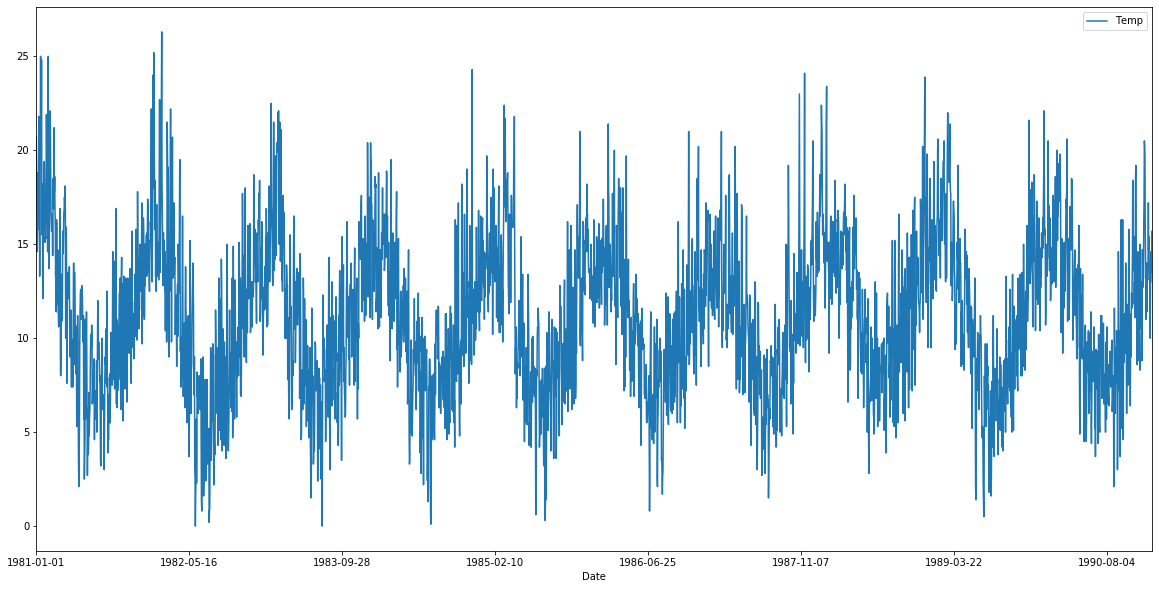

In [29]:
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0)
series.plot(figsize=(20,10))
plt.show()

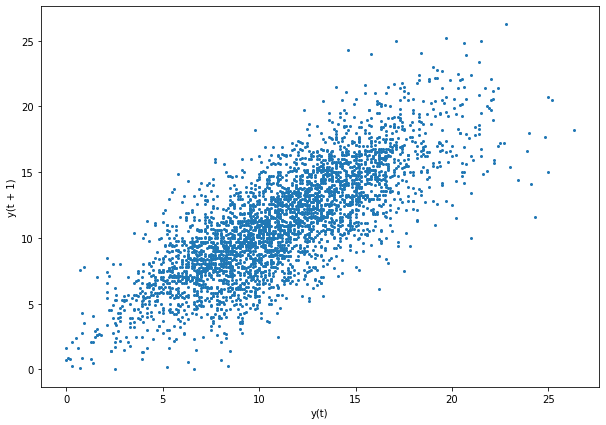

In [35]:
# Autocorrelation
from pandas.plotting import lag_plot
plt.figure(figsize=(10,7))
lag_plot(series, s=4)

In [38]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


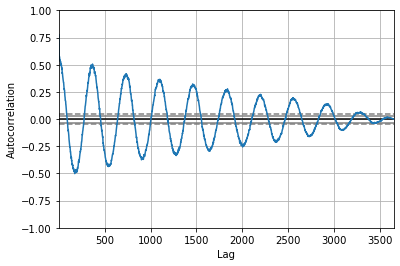

In [40]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values.

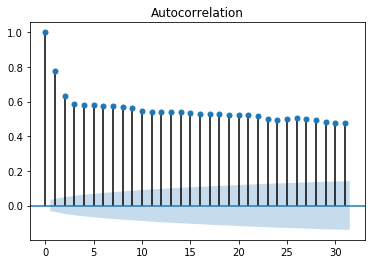

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=31)
plt.show()

#### Baseline Model

In [46]:
from sklearn.metrics import mean_squared_error
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0)
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

Test MSE: 3.423


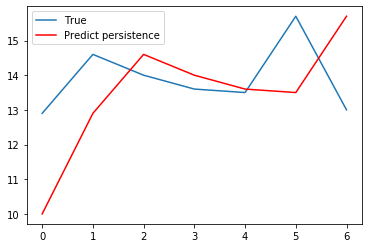

In [53]:
# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.legend(['True', 'Predict persistence'])
plt.show()

#### Autoregression Model Prediction

In [54]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]


predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


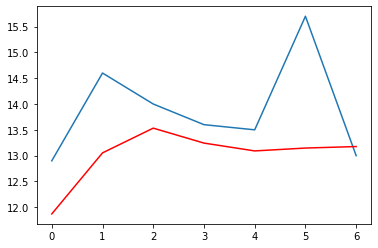

In [60]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

 #### Update the model as new observations become available.

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


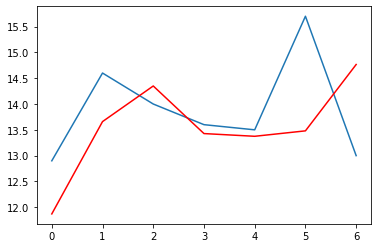

In [63]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## 2. Moving Average(MA)

The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.

The method is suitable for univariate time series without trend and seasonal components.

$X_{t}=\mu +\varepsilon _{t}+\theta _{1}\varepsilon _{{t-1}}+\cdots +\theta _{q}\varepsilon _{{t-q}}$

In [11]:
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARMA(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[0.59915188]


## 3.Autoregressive Moving Average (ARMA)

The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.

The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to an ARMA function, e.g. ARMA(p, q). An ARIMA model can be used to develop AR or MA models.

The method is suitable for univariate time series without trend and seasonal components.

$$X_{t}=c+\varepsilon _{t}+\sum _{i=1}^{p}\varphi _{i}X_{t-i}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}.\,$$

In [6]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = [random() for x in range(1, 100)]
# fit model
model = ARMA(data, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[0.45251424]


predicted=11.852050, expected=12.900000
predicted=13.543616, expected=14.600000
predicted=13.997215, expected=14.000000
predicted=14.210381, expected=13.600000
predicted=14.167724, expected=13.500000
predicted=14.290411, expected=15.700000
predicted=14.197628, expected=13.000000
Test RMSE: 0.960


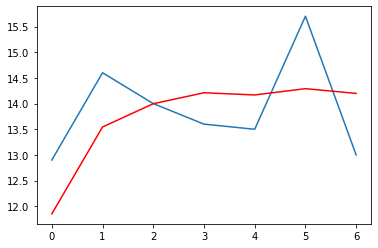

In [13]:
# Weather data
import math
from sklearn.metrics import mean_squared_error
# series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0)
# X = series.values
# train, test = X[1:len(X)-7], X[len(X)-7:]
# # train autoregression
# model = ARMA(train, order=(5, 5))
# model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## 4.Autoregressive Integrated Moving Average (ARMA)

The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.

The method is suitable for univariate time series with trend and without seasonal components.


$${\displaystyle X_{t}-\alpha _{1}X_{t-1}-\dots -\alpha _{p'}X_{t-p'}=\varepsilon _{t}+\theta _{1}\varepsilon _{t-1}+\cdots +\theta _{q}\varepsilon _{t-q'}}$$

Assume now that the polynomial ${\displaystyle \textstyle \left(1-\sum _{i=1}^{p'}\alpha _{i}L^{i}\right)}{\displaystyle \textstyle \left(1-\sum _{i=1}^{p'}\alpha _{i}L^{i}\right)} has a unit root (a factor {\displaystyle (1-L)}{\displaystyle (1-L)})$ of multiplicity d. Then it can be rewritten as:

$${\displaystyle \left(1-\sum _{i=1}^{p'}\alpha _{i}L^{i}\right)=\left(1-\sum _{i=1}^{p'-d}\phi _{i}L^{i}\right)\left(1-L\right)^{d}.}{\displaystyle \left(1-\sum _{i=1}^{p'}\alpha _{i}L^{i}\right)=\left(1-\sum _{i=1}^{p'-d}\phi _{i}L^{i}\right)\left(1-L\right)^{d}.}$$

In [16]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

[100.49761929]


### Example 2

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


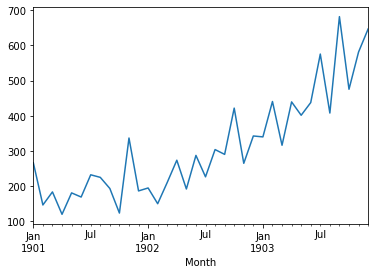

In [3]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

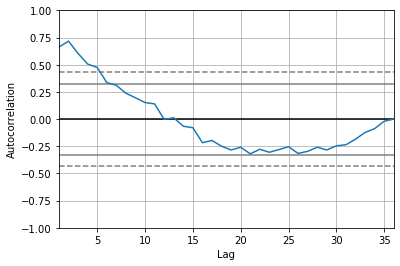

In [8]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Wed, 29 Apr 2020   AIC                            406.340
Time:                        17:30:09   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

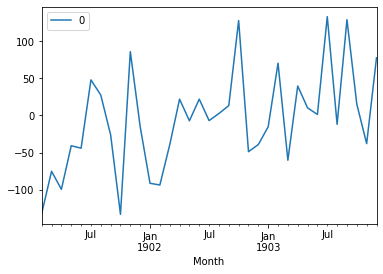

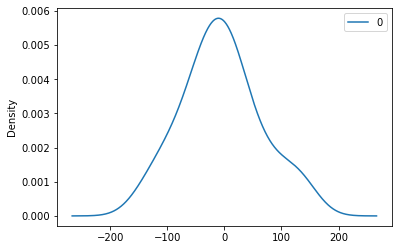

                0
count   35.000000
mean    -5.495267
std     68.132879
min   -133.296649
25%    -42.477975
50%     -7.186677
75%     24.748283
max    133.237923


In [10]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())